In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

This notebook reads CSV United Nations population tables and produces the numpy arrays to be read by the package when importing the population modules.
The original CSV file read in this notebook can be obtained here: https://population.un.org/wpp/Download/Standard/CSV/
and accessing the Total Population Sub Group file:
https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv

Population estimates are separated into 9 different *variants* for different combinations of fertility, mortality and international migration (which has different effects on different regions but cancels out at the *world* level).

The values used here come from the *median* variant which assumes median fertility and mortality.

In [3]:
pop = pd.read_csv('../../data/population/WPP2019_TotalPopulationBySex.csv')
pop.head()

,LocID,Location,VarID,Variant,Time,MidPeriod,PopMale,PopFemale,PopTotal,PopDensity
0,4,Afghanistan,2,Medium,1950,1950.5,4099.243,3652.874,7752.117,11.874
1,4,Afghanistan,2,Medium,1951,1951.5,4134.756,3705.395,7840.151,12.009
2,4,Afghanistan,2,Medium,1952,1952.5,4174.450,3761.546,7935.996,12.156
3,4,Afghanistan,2,Medium,1953,1953.5,4218.336,3821.348,8039.684,12.315
4,4,Afghanistan,2,Medium,1954,1954.5,4266.484,3884.832,8151.316,12.486


In [4]:
years = pd.unique(pop["Time"])
regions = pd.unique(pop["LocID"])
variants = pd.unique(pop["Variant"])

# Some numpy trickery to get the indices for the area, elements and items
iy = np.nonzero(pop['Time'].to_numpy()[:, None] == years)[1]
il = np.nonzero(pop['LocID'].to_numpy()[:, None] == regions)[1]
iv = np.nonzero(pop['Variant'].to_numpy()[:, None] == variants)[1]

# We compute the index in the flattened array
ipos = iy * len(regions) * len(variants) + il * len(variants) + iv
        
ipos = ipos.astype(int)

In [5]:
pop_arr = np.ones(len(years)*len(regions)*len(variants))*np.NaN
pop_arr[ipos] = pop['PopTotal']

pop_arr = pop_arr.reshape(len(years), len(regions), len(variants))

In [10]:
data = xr.Dataset(
    coords = dict(
        Year=("Year", years),
        Region=("Region", regions),
    )
)

for iv, variant in enumerate(variants):
    data = data.assign({variant:(["Year", "Region"], pop_arr[:,:,iv])})

In [14]:
regions

array([   4,  903, 1823, 1560, 2080, 2081, 2082, 2083, 2084, 1200,    8,
         12,   16, 1533,   20,   24,  660,   28,   32,   51,  533,  935,
       1207, 1824, 1557,   36,  927,   40,   31, 1525, 1526,   44,   48,
         50,   52,  112,   56,   84, 2067, 2068, 2069, 2070, 2071, 2072,
        204,   60,   64, 1527, 1569,   68,  535,   70,   72,   76,   92,
         96,  100,  854,  108,  132,  116,  120,  124,  915, 1530,  136,
        140,  916, 5500, 1545,  921,  148,  830,  152,  156, 1105,  344,
        446,  158,  170, 1566, 2074, 2075, 2076, 2077, 2078, 2079,  174,
        178,  184,  188, 1638, 2094, 2095, 2096, 2097, 2098, 2099,  191,
        192,  531,  196,  203,  384,  408,  180,  208, 1106,  262,  212,
        214, 1737, 1736, 1744, 1746, 1071, 1074, 1075, 1073, 1072, 2061,
       2058, 2059, 2060, 1054, 1057, 1055, 2049, 1060, 1059, 1058, 1056,
       2048, 2045, 2046, 2047, 2044, 2053, 1064, 2054, 2050, 1062, 2051,
       2055, 1065, 2052, 2056, 2062, 2066, 2065, 20

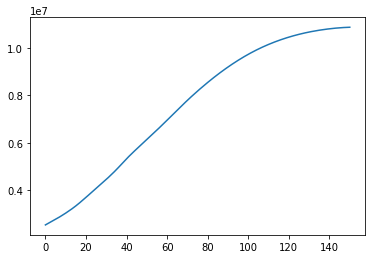

In [17]:
plt.plot(data.Medium.sel(Region=900))

In [19]:
encoding = {}

for variant in variants:
    encoding[variant] = {"dtype":"float32", "zlib": True, "complevel": 5}

data.to_netcdf("../../agrifoodpy/population/data/UN.nc", encoding = encoding)